# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 


<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm


In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ttest_ind
%matplotlib inline

df = pd.read_csv('data/human_body_temperature.csv')

### A Quick glance at the data we are working with:

In [23]:
print(df.head(5))
display(df.describe())
df.groupby('gender').size()

   temperature gender  heart_rate
0         99.3      F        68.0
1         98.4      F        81.0
2         97.8      M        73.0
3         99.2      F        66.0
4         98.0      F        73.0


,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000


gender
F    65
M    65
dtype: int64

## 1. Is the distribution of body temperatures normal?

#### Using graphical method, the distribution looks to be normal. When given a test of normality, the data returned a z=score of about 2.7 and a p-score of about 0.26, which means this test does not reject the null hypothesis. We should be able to conclude the body temperature is normally distributed


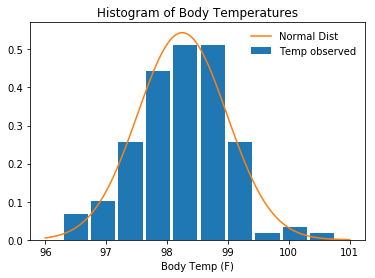

In [118]:
# Create a histogram of body temp and a normal distribution
plt.hist(df.temperature, width=0.4, normed=True, label='Temp observed')
plt.xlabel('Body Temp (F)')
plt.title('Histogram of Body Temperatures')

xs = np.linspace(96, 101, 100)
temp_mean = df.temperature.mean()
temp_std = df.temperature.std()
pdf = stats.norm.pdf(xs, temp_mean, temp_std)

plt.plot(xs, pdf, label='Normal Dist')
plt.legend(loc='best', frameon=False)
plt.show()

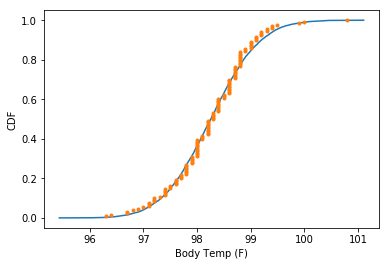

In [25]:
#Define a CDF function to calculate the CDF of an array
def cdf(data):
    x = np.sort(data)
    y = np.arange(1.0, len(data)+1) / len(data)
    
    return x, y

mean = np.mean(df.temperature)
std  = np.std(df.temperature)
normal = np.random.normal(mean, std, 10000)

# CDF of the sample and theoretical distributions
x, y = cdf(df.temperature)
x_norm, y_norm = cdf(normal)

plt.plot(x_norm, y_norm)
plt.plot(x, y, marker='.', ls='none')
plt.xlabel('Body Temp (F)')
plt.ylabel('CDF')
plt.show()

In [29]:
# Conduct a test of normality, where null hypothesis is that it is normal
stats.mstats.normaltest(df['temperature']) 

NormaltestResult(statistic=2.7038014333192031, pvalue=0.2587479863488254)

## 2. Is the sample size large? Are the observations independent?

#### There are 130 observations in this dataset, which is greater than the usual threshold of 30 observations. The observations should be independent if we assume they are all different people

In [30]:
df.count()

temperature    130
gender         130
heart_rate     130
dtype: int64

## 3. Is the true population mean really 98.6 degrees F?

#### Based on a boostrap hypothesis test and both a t and z test, I would reject the null hypothesis that the true population mean is 98.6 degrees. The data suggests that it is lower than 98.6 degrees, with a p-value less than 0.01 and no overlap in a 95% CI.
#### I would use the one-sample because we are only testing against the population mean , and a t-test because we do not know the population standard deviation. Though, a z-test would also give similar results because of the large sample data.

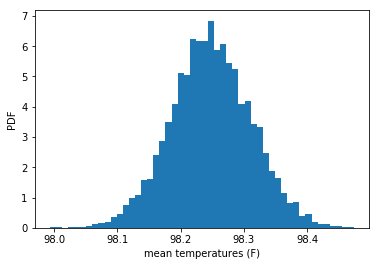

mean observed = 98.24923076923078
95% confidence interval = [ 98.12305769  98.37384615] degrees F


In [65]:
#Bootstrap Hypothesis Test

def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates


# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(df.temperature, np.mean, size=10000)


# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel('mean temperatures (F)')
_ = plt.ylabel('PDF')
plt.show()

print('mean observed =', mean)

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates, [2.5, 97.5])
print('95% confidence interval =', conf_int, 'degrees F')

In [77]:
# Use one-sample test with the null hypothesis that true population mean is 98.6 

#t_stat = (mean - 98.6)/se
t_stat = stats.ttest_1samp(df.temperature, 98.6)
print('The t-statistic and p-value are',  t_stat)

The t-statistic and p-value are Ttest_1sampResult(statistic=-5.4548232923645195, pvalue=2.4106320415561276e-07)


In [75]:
z_stat = sm.stats.ztest(df.temperature, value=98.6)
p_val = stats.norm.sf(np.abs(z_stat))*2
print('The z-statistic and p-value are', z_stat)

The z-statistic and p-value are (-5.4548232923645195, 4.9021570141012155e-08)


## 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

#### Both tests give similar results and because of the high p-value, we cannot reject that the smaller sample mean is different from the population mean. This result is the opposite of what we got earlier, simply because the sample size is not large enough. If you ran the same tests on a random sub sample of 30 (the minimum sample size suggested), you actually have a p-value under the standard alpha=0.05, meaning we could reject the null and suggest the findings are significant. At such small sample sizes the differences between the two tests are minimal, but as the size goes up the z-test is the better option and more reliable.

In [90]:
sm_sample = df.sample(10, random_state=30)
sm_sample

,temperature,gender,heart_rate
8,98.4,F,84.0
0,99.3,F,68.0
1,98.4,F,81.0
111,98.0,F,89.0
5,99.2,M,83.0
113,99.1,F,74.0
59,97.6,M,73.0
101,98.5,M,68.0
77,98.4,M,70.0
86,98.6,F,77.0


In [91]:
#Compute both t-test and z-test for the small sub sample
sm_t = stats.ttest_1samp(sm_sample.temperature, 98.6)
sm_z = sm.stats.ztest(sm_sample.temperature, value=98.6)
print('The t-test results are:', sm_t, ' and the z-test results are:', sm_z)

The t-test results are: Ttest_1sampResult(statistic=-0.29617443887952943, pvalue=0.77381728918044423)  and the z-test results are: (-0.29617443887952943, 0.76709686841029012)


In [89]:
#Create a medium sample with 30 observations
med_sample = df.sample(30, random_state=30)
print(med_sample.head())

#Compute both t-test and z-test for the medium sub sample
med_t = stats.ttest_1samp(med_sample.temperature, 98.6)
med_z = sm.stats.ztest(med_sample.temperature, value=98.6)
print('The t-test results for the medium sample are:', med_t, ' and the z-test results are:', med_z)

     temperature gender  heart_rate
8           98.4      F        84.0
0           99.3      F        68.0
1           98.4      F        81.0
111         98.0      F        89.0
5           99.2      M        83.0
The t-test results for the medium sample are: Ttest_1sampResult(statistic=-2.3083679258627536, pvalue=0.028305591890407242)  and the z-test results are: (-2.3083679258627536, 0.020978681364145612)


## 5. At what temperature should we consider someone's temperature to be "abnormal"?

#### There are many different ways of defining "abnormal." Looking at the confidence intervals for the sample data, I would say anything outside of the 95% CI is abnormal. So anything below 98.12 degrees or above 98.37. Using the 99% CI, you could say anything outside of the 98.08 - 98.41 range would be considered "abnormal." This is based on means of samples, so let's look at a more individual approach.

#### We can also think of this as testing for outliers. Generally an outlier is considered more than 3 std away from the mean, or a z-score less than -3 or more than 3. This suggests that anything below 96 or above 100.4 degrees is "abnormal." 

In [95]:
# Compute the 95% confidence interval: conf_int
conf1_int95 = np.percentile(bs1_replicate, [2.5, 97.5])
print('95% confidence interval =', conf_int95, 'degrees F')

# Compute the 99% confidence interval: conf_int
conf1_int99 = np.percentile(bs_replicates, [0.5, 99.5])
print('99% confidence interval =', conf_int99, 'degrees F')

95% confidence interval = [ 98.17230769  98.17230769] degrees F


In [100]:
lower = mean - std*3
upper = mean + std*3

print('Any value less than ', lower, ' or greater than ', upper, 'would be considered an outlier.')

Any value less than  96.05815743251567  or greater than  100.44030410594588 would be considered an outlier.


## 6. Is there a significant difference between males and females in normal temperature?

#### To explore the difference in gender, I use a two-sample t test because we are comparing two samples and the population standard deviation is unknown. The resulting p-value is less than half of 0.05 (alpha, but 1/2 on each side because we are testing if it is lower OR higher), so we can reject the null hypothesis and say that there is a significant difference between males and females in normal temperature.

In [126]:
#Separate male and female temps
m_temps = df[df['gender'] == 'M'].temperature
f_temps = df[df['gender'] == 'F'].temperature

#Perform t test
t_stat, p_val_t = ttest_ind(m_temps, f_temps)

print('The t-statistic is',t_stat)
print('The p value is',p_val_t)

The t-statistic is -2.28543453817
The p value is 0.0239318831224


In [141]:
avg_male = np.mean(m_temps)
avg_fem = np.mean(f_temps)

print('The average male temperature in the sample is ', avg_male, ' and the average female temperature is ', avg_fem)

m_std = np.std(m_temps)
f_std = np.std(f_temps)

The average male temperature in the sample is  98.1046153846154  and the average female temperature is  98.39384615384613


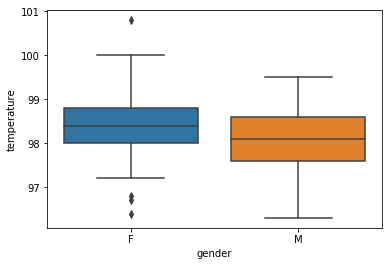

In [139]:
_ = sns.boxplot(x="gender", y="temperature", data=df)

## Conclusion: Based on our sample of 130 people split evenly between the genders, we can conclude that the average body temperature is actually lower than the 98.6 degrees fahrenheit that is usually suggested. The distribution of the sample is relatively normal. There is, however, a significant (based on alpha=0.05) difference between the genders' average body temperature. Men generally have a slightly lower body temperature. 